In [2]:
#Now to compute the r-ball

def compute_ball(adj,center,r):
    ball = {center}
    if r>0:
        for i in range(len(adj[center])):
            if adj[center][i] == 1:
                ball = ball.union(compute_ball(adj,i,r-1))
        return ball
    
    else:
        return ball

{1050}
{1069}
{1089}
{1106, 1068}
{1049, 1090, 1118}
{1134}
{1150}
{1168}
{1183}
{1198}
{1206}
set()


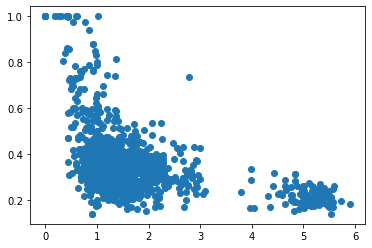

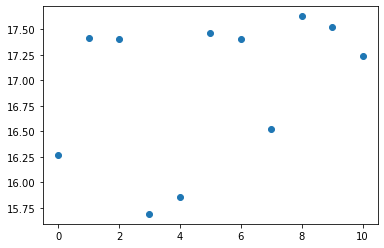

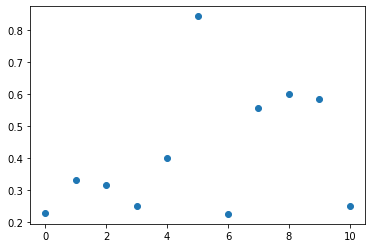

In [87]:
# Now pick up the vertices required and compute the distance required
import random
import linecache
from mhfp.encoder import MHFPEncoder
import json
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import rdFMCS

def compute_ball_avgs(file,query,processed_path, radius_max):
    file = open(file)
    graph = json.load(file)
    adj = np.zeros(shape = (len(graph['mapper']['nodes']),len(graph['mapper']['nodes'])))
    edges = graph['mapper']['links']
    lst1 = []
    lst2 = []
    lst3 = []

    for edge in edges:
        adj[edge['source']-1][edge['target']-1] = 1
        adj[edge['target']-1][edge['source']-1] = 1
    
    ref = random.choice(graph['mapper']['nodes'][query]['vertices'])
    mhfp_encoder = MHFPEncoder()
    line = linecache.getline(processed_path, int(ref)+2)
    struct = line.split(',')[-1]
    ref = mhfp_encoder.encode(struct)

    sphere = {}
    prev_ball = {}

    rdkgen = rdFingerprintGenerator.GetRDKitFPGenerator(fpSize=2048)

    for radius in range(radius_max):
        temp_ball = compute_ball(adj,query,radius)
        sphere = temp_ball.difference(prev_ball)
        print(sphere)
        temp = {}
        common = 0
        fp_dis = 0
        if len(sphere) != 0:
            for i in sphere:
                temp = set(graph['mapper']['nodes'][i]['vertices']).union(temp)

            for j in range(100):

                choice1 = random.choice(tuple(temp))
                choice2 = random.choice(tuple(temp))
                query_choice = random.choice(tuple(graph['mapper']['nodes'][query]['vertices']))

                query_line = linecache.getline(processed_path, query_choice+2)
                query_struct = query_line.split(',')[-1]
                #query_encoded_struct = mhfp_encoder.encode(query_struct)
                query_mol = Chem.MolFromSmiles(query_struct)
                query_fp = rdkgen.GetFingerprint(query_mol)

                line1 = linecache.getline(processed_path, choice1+2)
                struct1 = line1.split(',')[-1]
                #encoded_struc1 = mhfp_encoder.encode(struct1)
                mol1 = Chem.MolFromSmiles(struct1)
                fp1 = rdkgen.GetFingerprint(mol1)

                line2 = linecache.getline(processed_path, choice2+2)
                struct2 = line2.split(',')[-1]
                #encoded_struc2 = mhfp_encoder.encode(struct2)
                mol2 = Chem.MolFromSmiles(struct2)
                fp2 = rdkgen.GetFingerprint(mol2)

                vec1 = np.asarray(np.array(line1.split(',')[:-3]),dtype=float)
                vec2 = np.asarray(np.array(line2.split(',')[:-3]),dtype=float)
                query_vec = np.asarray(np.array(query_line.split(',')[:-3]),dtype=float)

                euc_dis = np.linalg.norm(vec1-vec2)
                fp_dis = DataStructs.TanimotoSimilarity(fp1,fp2)
                lst1.append([euc_dis,fp_dis])

                euc_dis = np.linalg.norm(query_vec - vec1)
                common = common + (rdFMCS.FindMCS([mol1,query_mol]).numAtoms)/100
                fp_dis = fp_dis + (DataStructs.TanimotoSimilarity(query_fp,fp1))/100
                
            graph_dis = radius
            lst2.append([graph_dis,common])
            lst3.append([graph_dis,fp_dis])
            prev_ball = temp_ball
        else:
            break
        
    return [lst1,lst2,lst3]

lists = compute_ball_avgs('./CLI_examples/final_100_50_1.5_10.json',1050,'./CLI_examples/processed_data.csv',15)

check = np.array(lists[0])
x = check[:,0]
y = check[:,1]
plt.scatter(x,y)
plt.show()

check = np.array(lists[1])
x = check[:,0]
y = check[:,1]
plt.scatter(x,y)
plt.show()

check = np.array(lists[2])
x = check[:,0]
y = check[:,1]
plt.scatter(x,y)
plt.show()

    

In [153]:
# The previous results do not look impresive.
# Let us start smallby first sampling across connected components
from rdkit.Chem import rdFMCS
from rdkit import Chem
import json
import numpy as np
import random
import linecache
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors

file = open('./CLI_examples/final_100_50_1.5_10.json')
graph = json.load(file)
adj = np.zeros(shape = (len(graph['mapper']['nodes']),len(graph['mapper']['nodes'])))
edges = graph['mapper']['links']
for i in range(len(graph['connected_components'])):
    if 4378 in graph['connected_components'][i]:
        component_number  = i

# Comparing the MCS between
common = 0
lst = []
count1 = 0
count2 = 0
count3 = 0
substruct_NO = Chem.MolFromSmiles("O-N=O")
substruct_F = Chem.MolFromSmiles("F")
substruct_Cl = Chem.MolFromSmiles("Cl")
substruct_Br = Chem.MolFromSmiles("Br")
substruct_I = Chem.MolFromSmiles("I")
nodes = [223]
for node in nodes:
    for i in range(100):
        #random_node1 = random.choice(graph['connected_components'][component_number])
        random_point1 = random.choice(graph['mapper']['nodes'][node]['vertices'])
        line1 = linecache.getline('./CLI_examples/processed_data.csv', random_point1+2)
        struct1 = line1.split(',')[-1]

        mol1 = Chem.MolFromSmiles(struct1)
        if rdMolDescriptors.CalcNumAmideBonds(mol1)!=0:
            count1 = count1 + 1
        
        if mol1.HasSubstructMatch(substruct_F) or mol1.HasSubstructMatch(substruct_Cl) or mol1.HasSubstructMatch(substruct_Br) or mol1.HasSubstructMatch(substruct_I):
            count2 = count2 + 1
        
        if mol1.HasSubstructMatch(substruct_NO):
            count3 = count3 + 1
        
        img = Draw.MolToImage(mol1)
        img.save("./CLI_examples/common/"+"vertex_"+str(i)+"_node_"+str(node)+'.png')
        lst.append(mol1)
print("Amide Perc: ",count1/(100*len(nodes)))
print("Halogen Perc: ",count2/(100*len(nodes)))
print("NO Perc: ",count3/(100*len(nodes)))

'''print("Amide Perc: ",count1/100)
for i in range(50):
    print(i)
    #random_node1 = random.choice(graph['connected_components'][148])
    random_point1 = random.choice(graph['mapper']['nodes'][1090]['vertices'])
    line1 = linecache.getline('./CLI_examples/processed_data.csv', random_point1+2)
    struct1 = line1.split(',')[-1]
    mol1 = Chem.MolFromSmiles(struct1)
    lst.append(mol1)

    img = Draw.MolToImage(Chem.MolFromSmarts(rdFMCS.FindMCS([mol1,mol2]).smartsString))
    random_node2 = random.choice(graph['connected_components'][148])
    random_point2 = random.choice(graph['mapper']['nodes'][random_node2]['vertices'])
    line2 = linecache.getline('./CLI_examples/processed_data.csv', random_point2+2)
    struct2 = line2.split(',')[-1]
    mol2 = Chem.MolFromSmiles(struct2)
    

    common = common + (rdFMCprint("Amide Perc: ",count1/100)S.FindMCS([mol1,mol2]).numAtoms)/100
    img = Draw.MolToImage(Chem.MolFromSmarts(rdFMCS.FindMCS([mol1,mol2]).smartsString))
    img.save("./CLI_examples/common/common_"+str(i)+".png")
'''
print(common)
img = Draw.MolToImage(Chem.MolFromSmarts(rdFMCS.FindMCS(lst).smartsString))
img.save('./CLI_examples/common/common.png')
    

Amide Perc:  0.55
Halogen Perc:  0.16
NO Perc:  0.0
0


In [13]:
#This is for debugging
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
from rdkit.Chem import PandasTools
PandasTools.RenderImagesInAllDataFrames(images=True)
import rdkit
from rdkit.Chem import rdRGroupDecomposition
import linecache

line1 = linecache.getline('./CLI_examples/processed_data.csv', 20)
struct = line1.split(',')[-2]
core = Chem.MolFromSmiles(struct)
struct = line1.split(',')[-1]
mol = Chem.MolFromSmiles(struct)
img = Draw.MolToImage(mol)
img.show()
rgd,fails = rdRGroupDecomposition.RGroupDecompose([core],[mol])
print(rgd)
img = Draw.MolsToGridImage(rgd[0].values(),legends=rgd[0].keys(),returnPNG=False)
img.save('sample.png')

[{'Core': <rdkit.Chem.rdchem.Mol object at 0x73e9ecae61f0>, 'R1': <rdkit.Chem.rdchem.Mol object at 0x73e9ecae6260>, 'R2': <rdkit.Chem.rdchem.Mol object at 0x73e9ecae6180>, 'R3': <rdkit.Chem.rdchem.Mol object at 0x73e9ecae5e70>, 'R4': <rdkit.Chem.rdchem.Mol object at 0x73e9ecae5540>}]


In [17]:
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.sping import PIL
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import BRICS
from PIL import Image
from PIL import ImageDraw
import linecache
import base64
from PIL import ImageFont
import numpy as np
import pandas as pd

lst = []

line = linecache.getline("./CLI_examples/processed_data.csv", 200)
structure = line.split(',')[-1]
mol = Chem.MolFromSmiles(structure)
pieces = [Chem.MolFromSmiles(x) for x in BRICS.BRICSDecompose(mol)]


pieces = [Chem.MolToSmiles(i) for i in pieces]
pieces = np.array(pieces)
print(pd.value_counts(pieces))
for i in pieces:
    img = Draw.MolToImage(Chem.MolFromSmiles(i))
    img.show()


#Draw.MolsToGridImage(pieces,molsPerRow=4)

[3*]O[3*]                  1
[5*]N[5*]                  1
[16*]c1cc(C)c(Cl)c(C)c1    1
[1*]C(=O)CCCCC[4*]         1
[4*]C(C)C(N)=O             1
Name: count, dtype: int64
